# 3x3 PPO

In [211]:
# imports 
from stable_baselines3 import DQN, PPO
import gymnasium as gym
import gym_gridworlds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [212]:
# make environment
# logging wrapper
LOG_DIR = "logs/"
MODEL_DIR = "trained_models/"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Wrap the environment with Monitor to log training progress
env = gym.make("Gym-Gridworlds/Penalty-3x3-v0", no_stay=True, distance_reward=True, start_pos = None)
env = Monitor(env, LOG_DIR)

In [213]:
# name = 'bssbs'
model = PPO(
    "MlpPolicy",
    env,
    n_steps=16,
    # batch_size= , # minibatch size
    learning_rate=1e-4,
    # n_epochs = ,# 🤷‍♀️
    # gamma = , # discount factor
    # ent_coef= , # entropy coefficient for loss calculation
    # vf_coef= , # value function for loss coefficient
    # target_kl = ,# Limit the KL divergence between updates
    stats_window_size = 100,
    # tensorboard_log=f"logs/{name}"
)

/Users/alisonandrade/Desktop/gym_gridworlds/.venv/lib/python3.14/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 16`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=16 and n_envs=1)
  warnings.warn(


In [214]:
# train model, progress bar w tdqm
print("--- Starting Training ---")
model.learn(total_timesteps=25000, progress_bar=True)
print( "--- Training Finished ---")

/Users/alisonandrade/Desktop/gym_gridworlds/.venv/lib/python3.14/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

--- Starting Training ---


--- Training Finished ---


In [215]:
model.save("trained_models/PPO_3x3")

In [216]:
eval_env = gym.make("Gym-Gridworlds/Penalty-3x3-v0", no_stay=True, distance_reward=True)
trained_model = PPO.load("trained_models/PPO_3x3")
mean_reward, std_reward = evaluate_policy(trained_model, eval_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: -0.67 +/- 0.00


/Users/alisonandrade/Desktop/gym_gridworlds/.venv/lib/python3.14/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


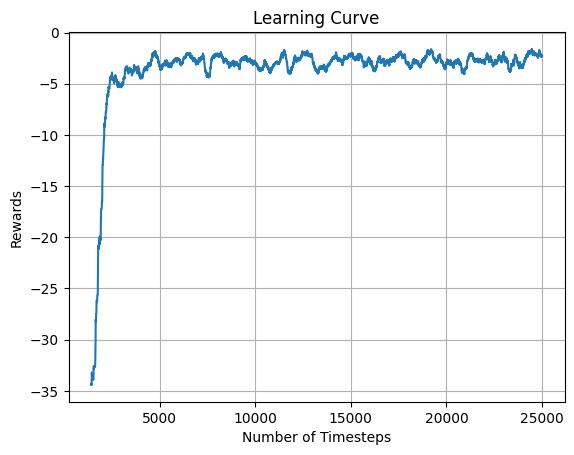

In [210]:
# Plotting the learning curve from the Monitor logs

# Helper function from Stable Baselines 3 to read monitor files
def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    # Smooth the curve using a moving average
    y = np.convolve(y, np.ones(100)/100, mode='valid')
    x = x[len(x) - len(y):]
    
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_results(LOG_DIR)

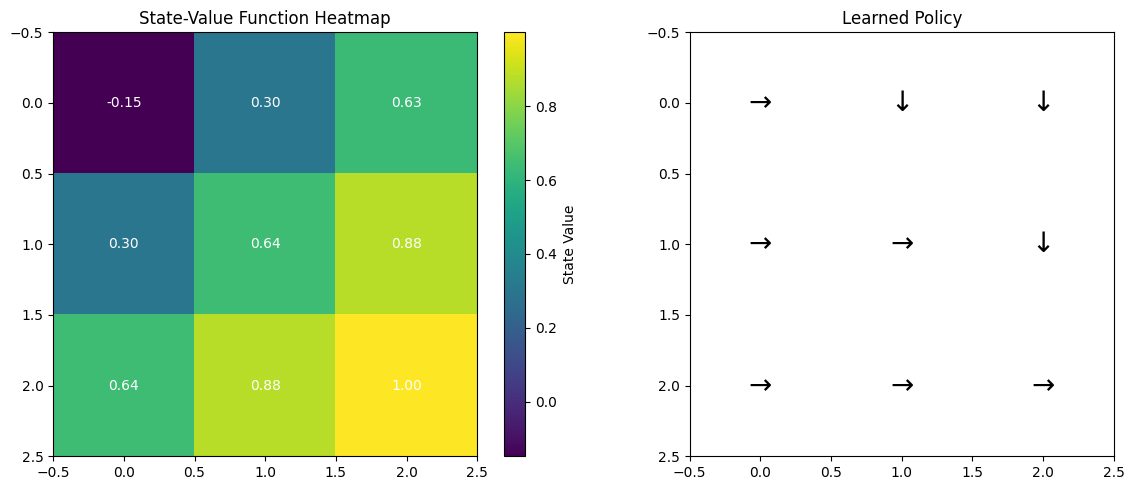

In [172]:
# Visualize the learned policy and value function
trained_model = PPO.load("trained_models/PPO_3x3")
grid_size = 3
policy_grid = np.zeros((grid_size, grid_size), dtype=int)
value_grid = np.zeros((grid_size, grid_size))

# Action mapping for arrows
# {0: LEFT, 1: DOWN, 2: RIGHT, 3: UP}
action_arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}

for i in range(grid_size):
    for j in range(grid_size):
        obs = i * grid_size + j
        # Note: The observation must be an array for the model
        action, _ = trained_model.predict(np.array([obs]), deterministic=True)
        policy_grid[i, j] = action[0]
        
        # Get the value from the policy's value function
        # The observation needs to be preprocessed by the policy
        obs_tensor, _ = trained_model.policy.obs_to_tensor(np.array([obs]))
        value = trained_model.policy.predict_values(obs_tensor)
        value_grid[i, j] = value.item()

# Plot Value Function Heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(value_grid, cmap='viridis')
plt.title('State-Value Function Heatmap')
plt.colorbar(label='State Value')
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{value_grid[i, j]:.2f}', ha='center', va='center', color='white')

# Plot Policy
plt.subplot(1, 2, 2)
plt.imshow(np.zeros_like(policy_grid), cmap='bone_r')
plt.title('Learned Policy')
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, action_arrows.get(policy_grid[i, j], ' '), ha='center', va='center', color='black', fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
policy_grid

array([[1, 1, 1],
       [2, 2, 1],
       [2, 2, 1]])